In [ ]:
# Install tensorflow 2.0 - restart the kernel if this is ran.
#!pip install -q tensorflow==2.0.0-alpha0

In [1]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
print(tf.__version__)

2.0.0-alpha0


In [2]:
# We'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

## Download and prepare the MS-COCO dataset

We will use the MS-COCO dataset to train our model. This dataset contains >82,000 images, each of which has been annotated with at least 5 different captions. The code below will download and extract the dataset automatically.

In [3]:
# Downloads a file from a URL if it not already in the cache.
annotation_zip = tf.keras.utils.get_file('captions.zip', 
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip, 
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
  PATH = os.path.abspath('.')+'/train2014/'

In [4]:
# read the json file as a dict
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [5]:
print(annotations.keys())
print(annotations['annotations'][:5])

dict_keys(['licenses', 'annotations', 'info', 'images'])
[{'image_id': 318556, 'caption': 'A very clean and well decorated empty bathroom', 'id': 48}, {'image_id': 116100, 'caption': 'A panoramic view of a kitchen and all of its appliances.', 'id': 67}, {'image_id': 318556, 'caption': 'A blue and white bathroom with butterfly themed wall tiles.', 'id': 126}, {'image_id': 116100, 'caption': 'A panoramic photo of a kitchen and dining room', 'id': 148}, {'image_id': 379340, 'caption': 'A graffiti-ed stop sign across the street from a red car ', 'id': 173}]


In [6]:
# storing the captions and the image name in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)
    
    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)
    
# shuffling the captions and image_names together
# setting a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

In [7]:
len(train_captions), len(all_captions)

(414113, 414113)

## Preprocess the images using InceptionV3
Next, we will use InceptionV3 (pretrained on Imagenet) to classify each image. We will extract features from the last convolutional layer.

First, we will need to convert the images into the format inceptionV3 expects by: * Resizing the image to (299, 299) * Using the preprocess_input method to place the pixels in the range of -1 to 1 (to match the format of the images used to train InceptionV3).

In [8]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

### Initialize InceptionV3 and load the pretrained Imagenet weights
To do so, we'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. * Each image is forwarded through the network and the vector that we get at the end is stored in a dictionary (image_name --> feature_vector). * We use the last convolutional layer because we are using attention in this example. The shape of the output of this layer is 8x8x2048. * We avoid doing this during training so it does not become a bottleneck. * After all the images are passed through the network, we pickle the dictionary and save it to disk.



In [9]:
image_model = tf.keras.applications.InceptionV3(include_top=False, 
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [10]:
#!pip install tqdm

In [11]:
# What do the image_name_vector look like?
print(img_name_vector[0])
print(len(img_name_vector))

/home/jupyter/Image_captioning/train2014/COCO_train2014_000000324909.jpg
414113


In [12]:
# getting the unique images
encode_train = sorted(set(img_name_vector))
print(len(img_name_vector))

414113


In [13]:
# feel free to change the batch_size according to your system configuration
# Because input elements are independent of one another, the pre-processing can be 
# parallelized across multiple CPU cores. To make this possible, the map transformation 
# provides the num_parallel_calls argument to specify the level of parallelism
# https://www.tensorflow.org/alpha/guide/data_performance
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [ ]:
# Because I ran out of memory, I want to run the batch process only on the features that
# haven't been created yet.

def batch_features_fun(img,path):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features, 
                                (batch_features.shape[0], -1, batch_features.shape[3]))
    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())
    
for img, path in image_dataset:
    for p in path:
        exists = os.path.exists(p.numpy().decode('utf-8') + '.npy')
        if not exists:
            batch_features_fun(img,path)

### Preprocess and tokenize the captions
- First, we'll tokenize the captions (e.g., by splitting on spaces). This will give us a vocabulary of all the unique words in the data (e.g., "surfing", "football", etc).
- Next, we'll limit the vocabulary size to the top 5,000 words to save memory. We'll replace all other words with the token "UNK" (for unknown).
- Finally, we create a word --> index mapping and vice-versa.

We will then pad all sequences to the be same length as the longest one.

In [14]:
# This will find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [15]:
# The steps above is a general process of dealing with text processing

# choosing the top 10000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, 
                                                  oov_token="<unk>", 
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [16]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [17]:
# creating the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [18]:
# padding each vector to the max_length of the captions
# if the max_length parameter is not provided, pad_sequences calculates that automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')


In [19]:
# calculating the max_length 
# used to store the attention weights
max_length = calc_max_length(train_seqs)

In [20]:
print(max_length)

52


In [21]:
# Create training and validation sets using 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector, 
                                                                    cap_vector, 
                                                                    test_size=0.2, 
                                                                    random_state=0)

In [22]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)


(331290, 331290, 82823, 82823)

In [23]:
# feel free to change these parameters according to your system's configuration

BATCH_SIZE = 128
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# shape of the vector extracted from InceptionV3 is (64, 2048)
# these two variables represent that
features_shape = 2048
attention_features_shape = 64
print(num_steps)

2588


In [24]:
# loading the numpy files 
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [25]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# using map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]), 
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

W0401 23:02:14.326571 140390623753984 deprecation.py:323] From /home/jupyter/.local/lib/python3.5/site-packages/tensorflow/python/ops/script_ops.py:476: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


### Model
Fun fact, the decoder below is identical to the one in the example for Neural Machine Translation with Attention.

The model architecture is inspired by the Show, Attend and Tell paper.

In this example, we extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
We squash that to a shape of (64, 2048).
This vector is then passed through the CNN Encoder(which consists of a single Fully connected layer).
The RNN(here GRU) attends over the image to predict the next word.

In [26]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)
  
  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
    
    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    
    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    
    # attention_weights shape == (batch_size, 64, 1)
    # we get 1 at the last axis because we are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    
    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [27]:
class CNN_Encoder(tf.keras.Model):
    # Since we have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)
        
    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [28]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    
    self.attention = BahdanauAttention(self.units)
        
  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)
    
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    
    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)
    
    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))
    
    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


In [29]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)


In [31]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, 
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

In [32]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  print('latest checkpoint')
  status = ckpt.restore(tf.train.latest_checkpoint(checkpoint_path))
  #status.assert_consumed()  # Optional sanity checks.
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

latest checkpoint


In [33]:
# Print checkpoint
#from tensorflow.python.tools import inspect_checkpoint as inschkp
#inschkp.print_tensors_in_checkpoint_file("./checkpoints/train/ckpt-1", tensor_name='', all_tensors=True)

### Training
We extract the features stored in the respective .npy files and then pass those features through the encoder.
The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
The decoder returns the predictions and the decoder hidden state.
The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
Use teacher forcing to decide the next input to the decoder.
Teacher forcing is the technique where the target word is passed as the next input to the decoder.
The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [34]:
# adding this in a separate cell because if you run the training cell 
# many times, the loss_plot array will be reset
loss_plot = []


In [35]:
@tf.function
def train_step(img_tensor, target):
  loss = 0
        
  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
  
  with tf.GradientTape() as tape:
      features = encoder(img_tensor)
      
      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)
          
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
  
  total_loss = (loss / int(target.shape[1]))
  
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  
  gradients = tape.gradient(loss, trainable_variables) 
  
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [ ]:
EPOCHS = 3

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    
    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        
        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    ckpt_manager.save()
    
    print ('Epoch {} Loss {:.6f}'.format(epoch + 1, 
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


In [38]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot


In [39]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))
    
    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()


Real Caption: <start> a desk with two computers is cluttered <end>
Prediction Caption: a desk with a computer and a computer monitor <end>


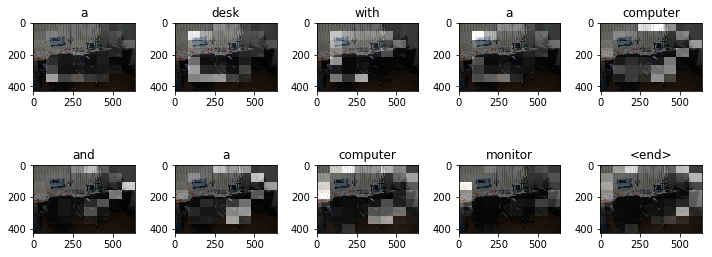

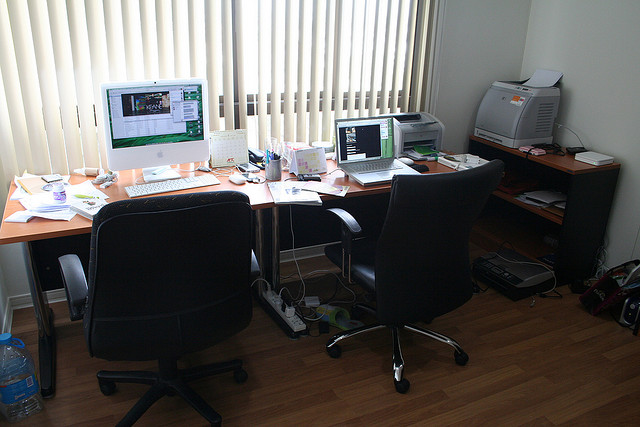

In [40]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)
# opening the image
Image.open(img_name_val[rid])


In [74]:
# Couldn't figure out how to restore weights so using checkpoint restoring instead.
#encoder.save_weights('weights/encoder/checkpoint')
#decoder.save_weights('weights/decoder/checkpoint')

In [41]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)